In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [3]:
table = Table().with_column("Numbers", make_array(1,2,3,4))
table

Numbers
1
2
3
4


In [39]:
table.sample(with_replacement=False)

Numbers
4
3
1
2


In [24]:
proportions = make_array(0.25,0.75)

400 * sample_proportions(400, proportions)


array([ 108.,  292.])

# Comparing Two Samples

In [25]:
births = Table.read_table('baby.csv')

In [26]:
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


In [27]:
smoking_and_birthweight = births.select('Maternal Smoker', 'Birth Weight')

In [28]:
smoking_and_birthweight.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


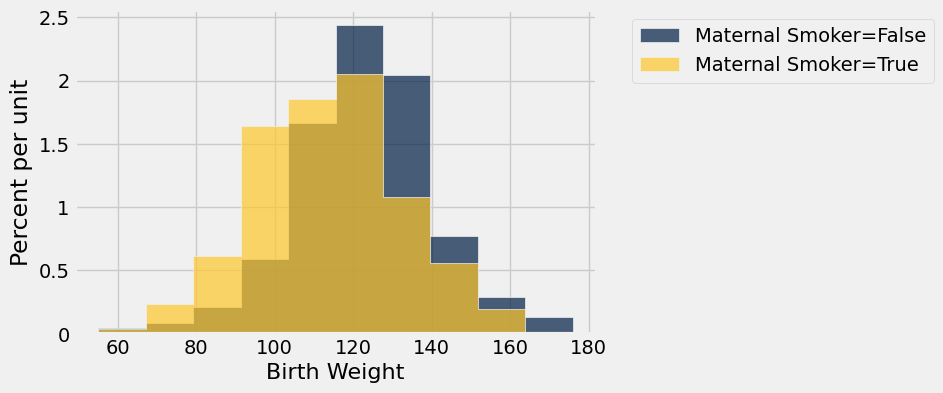

In [29]:
smoking_and_birthweight.hist('Birth Weight', group='Maternal Smoker')

# Test Statistic

[Question] What values of our statistic are in favor of the alternative: positive or negative?

In [30]:
means_table = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_table

Maternal Smoker,Birth Weight average
False,123.085
True,113.819


In [31]:
means = means_table.column(1)
observed_difference = means.item(1) - means.item(0)
observed_difference

-9.266142572024918

In [32]:
def difference_of_means(table, label, group_label):
    """Takes: name of table, column label of numerical variable,
    column label of group-label variable
    Returns: Difference of means of the two groups"""
    
    #table with the two relevant columns
    reduced = table.select(label, group_label)  
    
    # table containing group means
    means_table = reduced.group(group_label, np.average)
    # array of group means
    means = means_table.column(1)
    
    return means.item(1) - means.item(0)

In [33]:
difference_of_means(births, 'Birth Weight', 'Maternal Smoker')

-9.266142572024918

# Random Permutation (Shuffling)

In [40]:
letters = Table().with_column('Letter', make_array('a', 'b', 'c', 'd', 'e'))

In [41]:
letters.sample()

Letter
a
a
e
b
b


In [42]:
letters.sample(with_replacement = False)

Letter
c
d
b
e
a


In [43]:
letters.with_column('Shuffled', letters.sample(with_replacement = False).column(0))

Letter,Shuffled
a,d
b,c
c,b
d,a
e,e


# Simulation Under Null Hypothesis

In [44]:
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


In [45]:
shuffled_labels = smoking_and_birthweight.sample(with_replacement=False
                                                ).column('Maternal Smoker')

In [46]:
original_and_shuffled = smoking_and_birthweight.with_column(
    'Shuffled Label', shuffled_labels
)

In [47]:
original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Label
False,120,False
False,113,True
True,128,False
True,108,False
False,136,True
False,138,False
False,132,True
False,120,False
True,143,False
False,140,True


In [48]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Shuffled Label')

0.1813763578469576

In [49]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Maternal Smoker')

-9.266142572024918

# Permutation Test

In [51]:
def one_simulated_difference(table, label, group_label):
    """Takes: name of table, column label of numerical variable,
    column label of group-label variable
    Returns: Difference of means of the two groups after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = table.sample(with_replacement = False
                                                    ).column(group_label)
    
    # table of numerical variable and shuffled labels
    shuffled_table = table.select(label).with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, label, 'Shuffled Label')   

In [55]:
one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')

-0.061876685406090814

In [56]:
differences = make_array()

for i in np.arange(2500):
    new_difference = one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')
    differences = np.append(differences, new_difference)

Observed Difference: -9.266142572024918


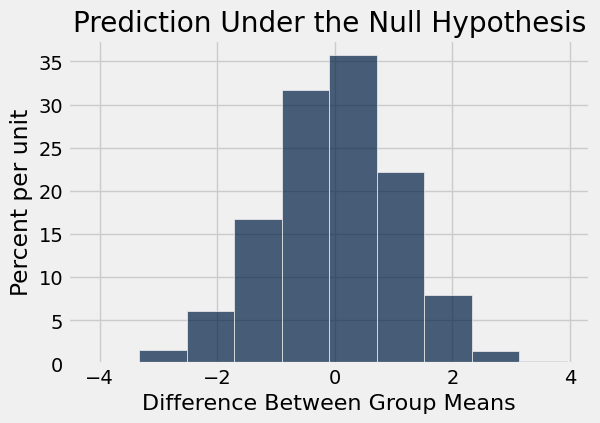

In [57]:
Table().with_column('Difference Between Group Means', differences).hist()
print('Observed Difference:', observed_difference)
plots.title('Prediction Under the Null Hypothesis');

# Randomized Control Experiment

In [58]:
botox = Table.read_table('bta.csv')
botox.show()

Group,Result
Control,1
Control,1
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0


In [59]:
botox.pivot('Result', 'Group')

Group,0.0,1.0
Control,14,2
Treatment,6,9


In [60]:
botox.group('Group', np.average)

Group,Result average
Control,0.125
Treatment,0.6


# Testing the Hypothesis

In [61]:
observed_diff = difference_of_means(botox, 'Result', 'Group')
observed_diff

0.475

In [65]:
one_simulated_difference(botox, 'Result', 'Group')

-0.041666666666666685

In [66]:
simulated_diffs = make_array()

for i in np.arange(10000):
    sim_diff = one_simulated_difference(botox, 'Result', 'Group')
    simulated_diffs = np.append(simulated_diffs, sim_diff)

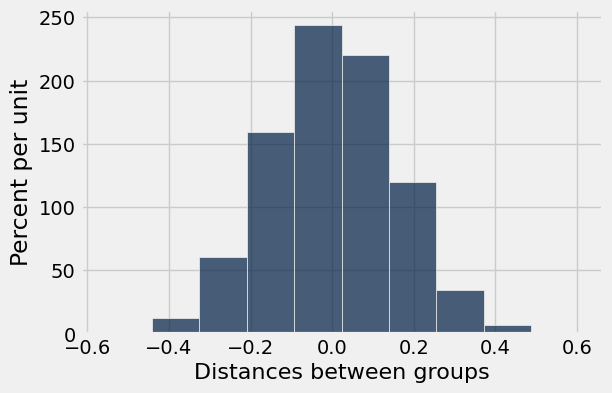

In [67]:
col_name = 'Distances between groups'
Table().with_column(col_name, simulated_diffs).hist(col_name)

In [68]:
# p-value
sum(simulated_diffs >= observed_diff)/len(simulated_diffs)

0.0088000000000000005

## Example: Benford's Law

In [69]:
digits = np.arange(1, 10)
benford_model = np.log10(1 + 1/digits)
benford_model

array([ 0.30103   ,  0.17609126,  0.12493874,  0.09691001,  0.07918125,
        0.06694679,  0.05799195,  0.05115252,  0.04575749])

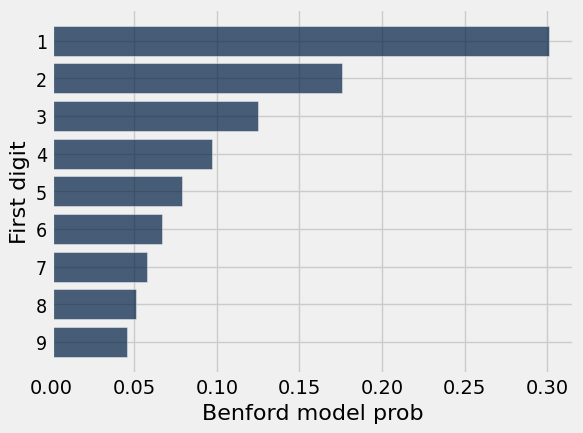

In [70]:
benford = Table().with_columns(
    'First digit', digits,
    'Benford model prob', benford_model)
benford.barh('First digit')

In [71]:
# You don't have to understand how this function works, since it uses Python features from beyond Data 8.
def first_digit(num):
    return int(str(num)[0])

In [72]:
first_digit(32)

3

In [73]:
first_digit(17719087)

1

In [74]:
# County populations from the census data
counties = Table.read_table('counties.csv')
counties = counties.where('SUMLEV', 50).select(5,6,9).relabeled(0,'State').relabeled(1,'County').relabeled(2,'Population')
counties.show(3)

State,County,Population
Alabama,Autauga County,54684
Alabama,Baldwin County,183216
Alabama,Barbour County,27336


In [75]:
first_digits = counties.apply(first_digit, 'Population')
counties = counties.with_column('First digit', first_digits)
counties.show(3)

State,County,Population,First digit
Alabama,Autauga County,54684,5
Alabama,Baldwin County,183216,1
Alabama,Barbour County,27336,2


In [76]:
num_counties = counties.num_rows

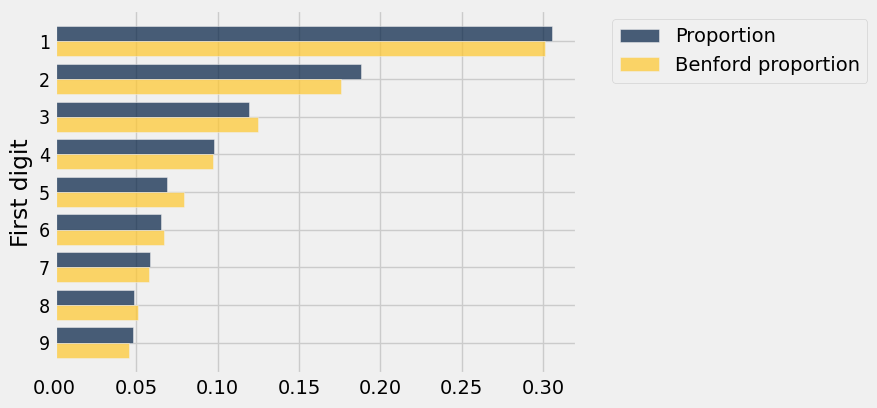

In [77]:
by_digit = counties.group('First digit')
proportions = by_digit.column('count')/num_counties
by_digit = by_digit.with_columns(
    'Proportion', proportions,
    'Benford proportion', benford_model
)
by_digit.drop('count').barh('First digit')

Null hypothesis:

Alternative hypothesis: 

Test statistic: ___

Fill in the blank with "Bigger" or "Smaller":

___ values of the test statistic favor the alternative

In [78]:
observed_tvd = sum(abs(proportions - benford_model))/2
observed_tvd

0.019227569718005835

In [79]:
sample_proportions(num_counties, benford_model)

array([ 0.30330999,  0.18045831,  0.12412476,  0.09548059,  0.08052196,
        0.06842775,  0.05601528,  0.05028644,  0.04137492])

In [80]:
simulated_frequencies = sample_proportions(num_counties, benford_model)
tvd = sum(abs(simulated_frequencies - benford_model))/2
tvd

0.019903935752404948

In [81]:
def simulate_county_first_digits():
    simulated_frequencies = sample_proportions(num_counties, benford_model)
    tvd = sum(abs(simulated_frequencies - benford_model))/2
    return tvd

In [82]:
simulated_tvds = make_array()

for i in np.arange(10000):
    simulated_tvds = np.append(simulated_tvds, simulate_county_first_digits())

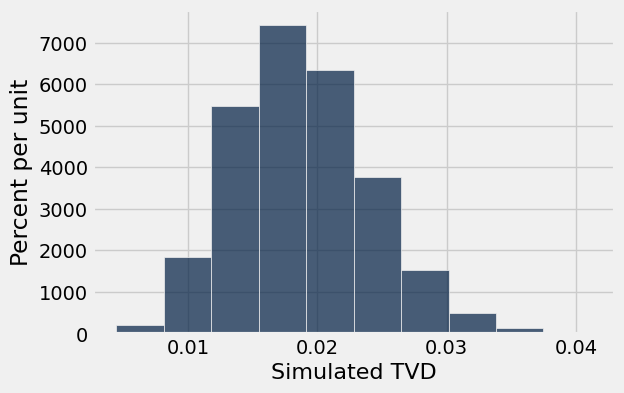

In [83]:
Table().with_column('Simulated TVD', simulated_tvds).hist(0)

In [84]:
np.count_nonzero(simulated_tvds >= observed_tvd) / 10000

0.4457

Are the data consistent with the null hypothesis?

## Example: sleep survey

In [ ]:
survey = Table.read_table('welcome_survey_v4.csv')
survey

In [ ]:
def simplify(sleep_position):
    if sleep_position == 'On your left side' or sleep_position == 'On your right side':
        return 'side'
    else:
        return 'back or stomach'
    
survey = survey.with_column(
    'position',
    survey.apply(simplify, 'Sleep position')
).select('position', 'Hours of sleep')

survey

In [ ]:
survey.group('position', np.average)

Null hypothesis: 

Alternative hypothesis: 

Test statistic: ___

Fill in the blank with "Bigger" or "Smaller":

___ values of the test statistic favor the alternative

In [ ]:
def compute_test_statistic(tbl):
    grouped = tbl.group('position', np.average)
    avgs = grouped.column('Hours of sleep average')
    return avgs.item(1) - avgs.item(0)

In [ ]:
obs_test_stat = compute_test_statistic(survey)
obs_test_stat

In [ ]:
random_labels = survey.sample(with_replacement=False).column('position')
random_labels

In [ ]:
def simulate_under_null():
    random_labels = survey.sample(with_replacement=False).column('position')
    relabeled_tbl = survey.with_column('position', random_labels)
    return compute_test_statistic(relabeled_tbl)


In [ ]:
simulated_diffs = make_array()
for i in np.arange(1000):
    null_stat = simulate_under_null()
    simulated_diffs = np.append(simulated_diffs, null_stat)

In [ ]:
Table().with_column('Simulated difference', simulated_diffs).hist(0)

In [ ]:
obs_test_stat

In [ ]:
np.mean(simulated_diffs <= obs_test_stat)

Are the data consistent with the null hypothesis?

### Percentiles

In [85]:
# Manually compute the 55th percentile.
x = make_array(43, 20, 51, 7, 28, 34)

In [86]:
# Step 1. Sort the data
np.sort(x)

array([ 7, 20, 28, 34, 43, 51])

In [ ]:
# Step 2. Figure out where 55th percentile would be.

In [87]:
# OR: 1 Line of Code
percentile(55, x)

34

In [88]:
s = make_array(1, 7, 3, 9, 5)

In [90]:
percentile(10, s)

1

In [91]:
percentile(39, s) == percentile(40, s)

True

In [92]:
percentile(40, s) == percentile(41, s)

False

In [93]:
percentile(50, s) == 5

True

### Sample Median

In [94]:
sf = Table.read_table('san_francisco_2015.csv')
sf

Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
Calendar,2015,2,"Public Works, Transportation & Commerce",WTR,PUC Water Department,21,"Prof & Tech Engineers - Miscellaneous, Local 21",2400,"Lab, Pharmacy & Med Techs",2481,Water Qualitytech I/II,21538,82146,0,0,82146,16942.2,12340.9,6337.73,35620.8,117767
Calendar,2015,2,"Public Works, Transportation & Commerce",DPW,General Services Agency - Public Works,12,"Carpet, Linoleum and Soft Tile Workers, Local 12",7300,Journeyman Trade,7393,Soft Floor Coverer,5459,32165.8,973.19,848.96,33987.9,0,4587.51,2634.42,7221.93,41209.8
Calendar,2015,4,Community Health,DPH,Public Health,790,"SEIU - Miscellaneous, Local 1021",1600,"Payroll, Billing & Accounting",1636,Health Care Billing Clerk 2,41541,71311,5757.98,0,77069,14697.6,12424.5,6370.06,33492.2,110561
Calendar,2015,4,Community Health,DPH,Public Health,351,Municipal Executive Association - Miscellaneous,0900,Management,2620,Food Service Mgr Administrator,26718,28430.2,0,763.07,29193.3,0,4223.14,5208.51,9431.65,38625
Calendar,2015,2,"Public Works, Transportation & Commerce",MTA,Municipal Transportation Agency,790,"SEIU - Miscellaneous, Local 1021",8200,Protection & Apprehension,8201,School Crossing Guard,45810,7948.75,0,0,7948.75,0,2873.17,616.24,3489.41,11438.2
Calendar,2015,1,Public Protection,POL,Police,911,Police Officers' Association,Q000,Police Services,Q002,Police Officer,32906,2235,0,0,2235,490.36,286.72,176.57,953.65,3188.65
Calendar,2015,4,Community Health,DPH,Public Health,791,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2328,Nurse Practitioner,7506,187247,0,11704.1,198951,37683.7,12424.5,11221.7,61329.9,260281
Calendar,2015,2,"Public Works, Transportation & Commerce",MTA,Municipal Transportation Agency,253,"Transport Workers - Transit Operators, Local 250-A",9100,Street Transit,9163,Transit Operator,36773,66988.5,3512.88,2770.39,73271.8,19127.2,13203,5455.1,37785.3,111057
Calendar,2015,6,General Administration & Finance,CAT,City Attorney,311,Municipal Attorneys' Association,8100,Legal & Court,8177,Attorney (Civil/Criminal),12963,135190,0,1562.5,136752,27501.8,12424.5,10103,50029.3,186781
Calendar,2015,3,Human Welfare & Neighborhood Development,DSS,Human Services,535,"SEIU - Human Services, Local 1021",9700,Community Development,9703,Emp & Training Spec 2,35179,70474.8,147.28,1647.24,72269.3,14650.3,10696.9,5993.11,31340.3,103610


In [95]:
# Who is making the most money
sf.sort('Total Compensation', descending=True).show(5)

Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
Calendar,2015,6,General Administration & Finance,RET,Retirement System,351,Municipal Executive Association - Miscellaneous,1100,Administrative & Mgmt (Unrep),1119,Chief Investment Officer,46881,507832,0,0,507832,105053,12424.5,23566.2,141044,648875
Calendar,2015,6,General Administration & Finance,ADM,General Services Agency - City Admin,164,Physicians and Dentists - Miscellaneous,2500,Med Therapy & Auxiliary,2598,Asst Med Examiner,1016,279311,3829.36,114434,397574,56211.6,12424.5,14299.1,82935.2,480509
Calendar,2015,6,General Administration & Finance,ADM,General Services Agency - City Admin,164,Physicians and Dentists - Miscellaneous,2500,Med Therapy & Auxiliary,2598,Asst Med Examiner,13746,279311,9046.92,56742.6,345101,56211.6,12424.5,13482.7,82118.8,427219
Calendar,2015,2,"Public Works, Transportation & Commerce",AIR,Airport Commission,351,Municipal Executive Association - Miscellaneous,0900,Management,0965,Dept Head V,17356,326764,0,0,326764,65806.3,12424.5,21691.2,99922.1,426686
Calendar,2015,4,Community Health,DPH,Public Health,351,Municipal Executive Association - Miscellaneous,0900,Management,1164,"Adm, SFGH Medical Center",1523,256098,0,82292.3,338390,51977.5,11468.8,20963.3,84409.6,422800


In [96]:
# Who is making the least money
sf.sort('Total Compensation', descending=False).show(5)

Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
Calendar,2015,1,Public Protection,FIR,Fire Department,798,"Firefighters - Miscellaneous, Local 798",H000,Fire Services,H002,Firefighter,43833,0,0,0,0,0,0,-423.76,-423.76,-423.76
Calendar,2015,4,Community Health,DPH,Public Health,790,"SEIU - Miscellaneous, Local 1021",9900,Public Service Aide,9924,PS Aide Health Services,27871,-292.4,0,0,-292.4,0,-95.58,-22.63,-118.21,-410.61
Calendar,2015,1,Public Protection,JUV,Juvenile Probation,790,"SEIU - Miscellaneous, Local 1021",8300,Correction & Detention,8320,"Counselor, Juvenile Hall",10517,0,0,0,0,0,0,-159.12,-159.12,-159.12
Calendar,2015,6,General Administration & Finance,CPC,City Planning,21,"Prof & Tech Engineers - Miscellaneous, Local 21",1000,Information Systems,1053,IS Business Analyst-Senior,18961,0,0,0,0,0,0,-26.53,-26.53,-26.53
Calendar,2015,6,General Administration & Finance,CPC,City Planning,21,"Prof & Tech Engineers - Miscellaneous, Local 21",5200,Professional Engineering,5277,Planner 1,19387,0,0,0,0,0,0,-9.51,-9.51,-9.51


In [97]:
min_salary = 10 * 20 * 52
sf = sf.where('Total Compensation', are.above(min_salary))

In [98]:
pop_median = percentile(50, sf.column('Total Compensation'))
pop_median

107516.69

In [99]:
our_sample = sf.sample(300, with_replacement=False)
our_sample.show(5)

Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
Calendar,2015,3,Human Welfare & Neighborhood Development,DSS,Human Services,535,"SEIU - Human Services, Local 1021",2900,Human Services,2918,HSA Social Worker,48010,79395,0,624,80019,16492.4,12424.5,6552.88,35469.8,115489
Calendar,2015,4,Community Health,DPH,Public Health,21,"Prof & Tech Engineers - Miscellaneous, Local 21",2500,Med Therapy & Auxiliary,2593,Health Program Coordinator 3,11476,101531,0,0,101531,20926,12424.5,8234.85,41585.4,143116
Calendar,2015,3,Human Welfare & Neighborhood Development,DSS,Human Services,535,"SEIU - Human Services, Local 1021",2900,Human Services,2940,Protective Services Worker,27395,37450,0,0,37450,6969.48,5734.39,3036.63,15740.5,53190.5
Calendar,2015,4,Community Health,DPH,Public Health,791,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,29856,149099,5.34,31603,180707,34742.9,12424.5,7622,54789.4,235497
Calendar,2015,4,Community Health,DPH,Public Health,790,"SEIU - Miscellaneous, Local 1021",9900,Public Service Aide,9910,Public Service Trainee,19873,8190,0,0,8190,0,2150.39,651.09,2801.48,10991.5


In [100]:
percentile(50, our_sample.column('Total Compensation'))

116585.46000000001

/home/shaolin/Documents/Teaching/2023/cs2065/venv/lib/python3.9/site-packages/datascience/tables.py:5865: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(ticks, rotation='vertical')


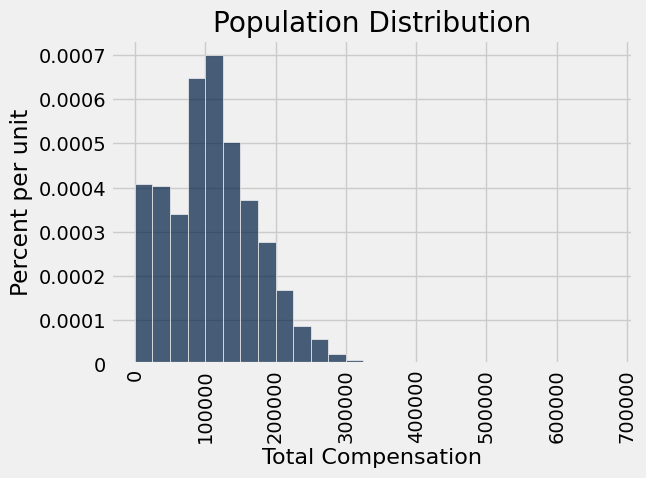

In [101]:
sf_bins = np.arange(0, 700000, 25000)
sf.hist('Total Compensation', bins=sf_bins)
plots.title('Population Distribution');

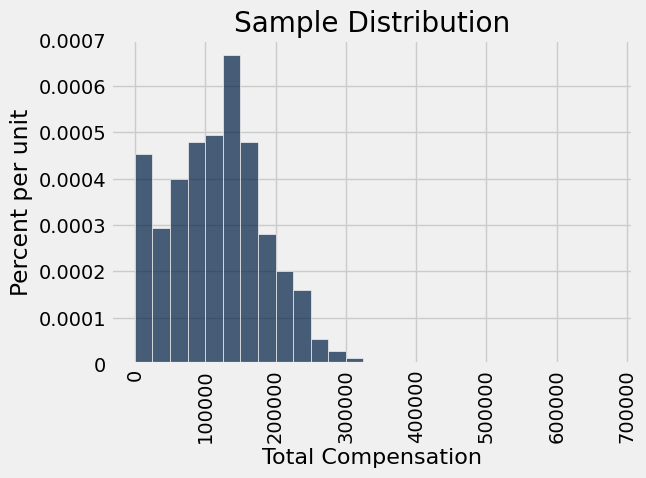

In [102]:
our_sample.hist('Total Compensation', bins=sf_bins)
plots.title('Sample Distribution');

# Variability of the Estimate

In [103]:
def generate_sample_median(samp_size):
    our_sample = sf.sample(samp_size, with_replacement=False)
    return percentile(50, our_sample.column('Total Compensation'))

In [104]:
sample_median = generate_sample_median(300)
sample_median

111700.14999999999

In [105]:
error = sample_median - pop_median
error

4183.4599999999919

# Quantifying Uncertainty

In [106]:
sample_medians = make_array()

for i in np.arange(1000):
    new_median = generate_sample_median(300)
    sample_medians = np.append(sample_medians, new_median)

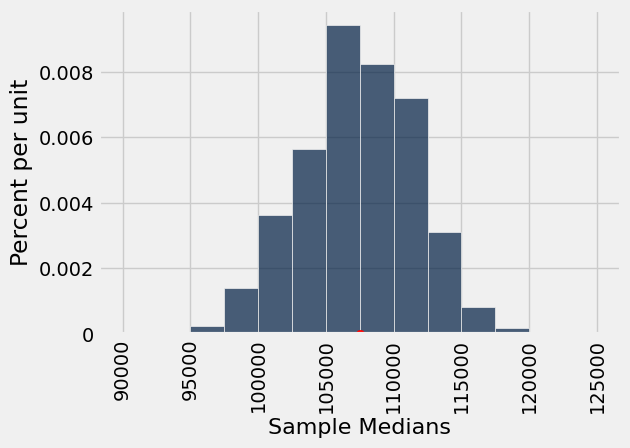

In [107]:
med_bins = np.arange(90000, 125001, 2500)
Table().with_column(
    'Sample Medians', sample_medians
).hist(bins = med_bins)

plots.scatter(pop_median, 0, color="red");

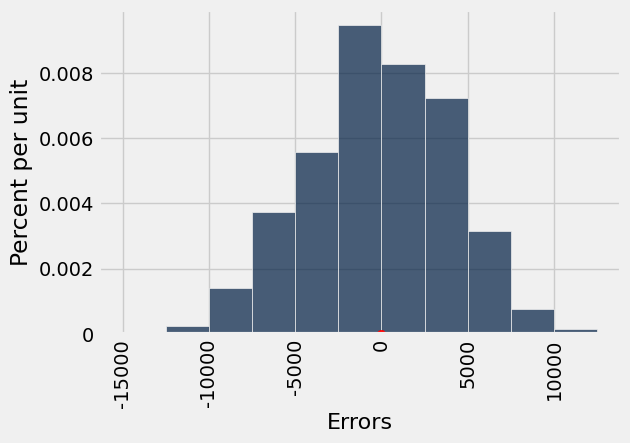

In [108]:
err_bins = np.arange(-15000, 12501, 2500)
Table().with_column(
    'Errors', sample_medians - pop_median
).hist(bins = err_bins)

plots.scatter(0, 0, color="red");

# Bootstrap

In [ ]:
# Take a bootstrap (re)sample of size 300, WITH replacement
boot_sample = our_sample.sample(300, with_replacement=True)
boot_sample.hist('Total Compensation', bins=sf_bins)
plots.title('Bootstrap sample');

print("Population Median =       ", pop_median)
print("Our Sample Median =       ", sample_median)
print("Bootstrap Sample Median = ", 
      percentile(50,boot_sample.column('Total Compensation')))

In [ ]:
def one_bootstrap_median():
    single_sample = our_sample.sample()
    return percentile(50, single_sample.column('Total Compensation'))

In [ ]:
bootstrap_medians = make_array()
for i in np.arange(1000):
    new_median = one_bootstrap_median()
    bootstrap_medians = np.append(bootstrap_medians, new_median)

In [ ]:
Table().with_column(
    'Bootstrap Medians', bootstrap_medians
).hist('Bootstrap Medians', bins=med_bins)

plots.scatter(pop_median, 0, color="red");
plots.scatter(sample_median, 0, color="blue");